In [1]:
import matplotlib.pyplot as plt
import cv2

In [2]:
image_dir = './VOCdevkit/VOC2012/JPEGImages/'
test_image = '2012_000040.jpg'
image_path = image_dir + test_image
I = plt.imread(image_dir + test_image)
I.shape

(374, 500, 3)

In [3]:
img = cv2.imread(image_path)
img.shape

(374, 500, 3)

In [4]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_image.shape

(374, 500)

In [5]:
lower_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_lowerbody.xml")
body_classifier  = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_fullbody.xml")
body  = body_classifier.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=2, minSize=(10, 10))

In [6]:
for (x, y, w, h) in body: cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 128), 3)

In [7]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Ejercicio 1

In [8]:
walking_train_txt_dir = './VOCdevkit/VOC2012/ImageSets/Action/walking_train.txt' 

In [9]:
file_path = walking_train_txt_dir
with open(file_path, 'r') as file:
		lines = file.readlines()

data = []
for line in lines:
		line = line.strip()
		file_name = line.split('  ')[0]
		if not file_name.startswith('2012'): continue
		object_idx = line.split('  ')[1]	
		object_in  = line.split('  ')[2]
		if object_in != '1': continue
		data.append([
				file_name,
				object_idx,
				object_in
		])

In [10]:
import cv2
# X is the numpy array of pictures in data
X = []
Y = []
image_dir = './VOCdevkit/VOC2012/JPEGImages/'
observed_images = []
for d in data:
	file_name = d[0] + '.jpg'
	if file_name in observed_images: continue
	X.append(file_name)
	observed_images.append(file_name)
	


In [11]:

'''
Detects full body in a picture
'''
def detect_full_body_cascade(image_path):
		img = cv2.imread(image_path)
		gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
		body_classifier  = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_fullbody.xml")
		body  = body_classifier.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=2, minSize=(10, 10))
		boxes = []
		image_width = img.shape[1]
		image_height = img.shape[0]
		for (x, y, w, h) in body:
				boxes.append([x/image_width, (x + w)/image_width,y/image_height, (y + h)/image_height])					
		return boxes		

In [12]:
for image in X:
		boxes = detect_full_body_cascade(image_dir + image)
		Y.append(boxes)

In [13]:
def draw_boxes(image_path, boxes):
		img = cv2.imread(image_path)
		for box in boxes:
				x1 = int(box[0] * img.shape[1])
				x2 = int(box[1] * img.shape[1])
				y1 = int(box[2] * img.shape[0])
				y2 = int(box[3] * img.shape[0])
				cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 128), 3)
		return img

In [14]:
# import ET
import xml.etree.ElementTree as ET
# Obtain real data

def obtain_real_boxes(image_name):
		# Obtain .xml file
		xml_file_name = image_name.replace('.jpg', '.xml')
		xml_file_path = './VOCdevkit/VOC2012/Annotations/' + xml_file_name

		# Read the xml file
		tree = ET.parse(xml_file_path)
		root = tree.getroot()
		# Get <size> tag
		size = root.find('size')
		width, height = int(size.find('width').text), int(size.find('height').text)
		# Get <object> tags
		objects = root.findall('object')
		boxes = []
		# get <actions> tags inside <object> tags
		for obj in objects:
				actions = obj.find('actions')
				# if <walking> tag value is not 1, continue
				walking = actions.find('walking').text
				if walking != '1': continue
				# Get <bndbox> tags inside <actions> tags
				bndbox = obj.findall('bndbox')
				
				for box in bndbox:
						# Get <xmin>, <xmax>, <ymin>, <ymax> tags inside <bndbox> tags
						xmin = int(box.find('xmin').text) / width
						xmax = int(box.find('xmax').text) / width
						ymin = int(box.find('ymin').text) / height
						ymax = int(box.find('ymax').text) / height
						boxes.append([xmin, xmax, ymin, ymax])
		return boxes
		

In [15]:
Y_real = []
for img in X: Y_real.append(obtain_real_boxes(img))

In [16]:
def show_comparison(num):
    num = num-1
    img_detected = draw_boxes(image_dir + X[num], Y[num])
    img_detected_rgb = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)

    img_real = draw_boxes(image_dir + X[num], obtain_real_boxes(X[num]))
    img_real_rgb = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(11,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_detected_rgb)
    plt.title('Detected')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_real_rgb)
    plt.title('Real')
    plt.axis('off')

    plt.show()

In [17]:
def calculate_j_index(b1, b2):

    x11, x12, y11, y12 = b1
    x21, x22, y21, y22 = b2

    x_area = (min(x12, x22) - max(x11, x21)) if min(x12, x22) - max(x11, x21) > 0 else 0
    y_area = (min(y12, y22) - max(y11, y21)) if min(y12, y22) - max(y11, y21) > 0 else 0
    intersection_area = x_area * y_area
    
    union_area = ((x12 - x11) * (y12 - y11)) + ((x22 - x21) * (y22 - y21)) - intersection_area
    
    return intersection_area / union_area if union_area != 0 else 0.0

def get_all_j_index(num):
    j_indxs = []
    num = num-1
    yy_real = Y_real[num]
    yy = Y[num]
    
    for i in range(len(yy_real)):
        for j in range(len(yy)):
            indx = calculate_j_index(yy_real[i], yy[j]) 
            if indx != 0: j_indxs.append(indx)

    mean = (sum(j_indxs) / len(j_indxs)) if len(j_indxs) != 0 else "NA"
    return mean, j_indxs
    

In [18]:
def get_metrics(TP, FP, FN, no):
    pre = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    print(f'Precision: {pre}')

    rec = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    print(f'Recall: {rec}')

    f1_sc= 2 * pre * rec / (pre + rec) if pre + rec != 0 else 0.0
    print(f'F1 Score: {f1_sc}')

    mean_j, list_j = get_all_j_index(no)
    print(f'Jaccard Indexes: {list_j}')
    print(f'Jaccard Index(Mean): {mean_j}')

    return pre, rec, f1_sc, mean_j


## Métricas

In [19]:
precisions_list = []
recalls_list = []
f1_scores_list = []
jis_list = []

### Imagen 1

In [20]:
no = 1
show_comparison(no)

In [21]:
TP1 = 0
FP1 = 0
FN1 = 1

precision1, recall1, F1_score1, j_mean1 = get_metrics(TP1, FP1, FN1, no)

precisions_list.append(precision1)
recalls_list.append(recall1)
f1_scores_list.append(F1_score1)
jis_list.append(j_mean1)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 2

In [22]:
no = 2
show_comparison(no)

In [23]:
TP2 = 0
FP2 = 0
FN2 = 1

precision2, recall2, F1_score2, j_mean2 = get_metrics(TP2, FP2, FN2,no)

precisions_list.append(precision2)
recalls_list.append(recall2)
f1_scores_list.append(F1_score2)
jis_list.append(j_mean2)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 3

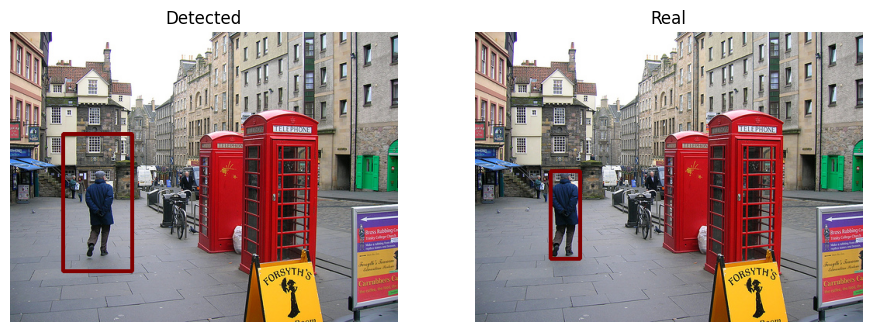

In [24]:
no = 3
show_comparison(no)

In [25]:
TP3 = 1
FP3 = 0
FN3 = 0

precision3, recall3, F1_score3, j_mean3 = get_metrics(TP3, FP3, FN3, no)

precisions_list.append(precision3)
recalls_list.append(recall3)
f1_scores_list.append(F1_score3)
jis_list.append(j_mean3)


Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Jaccard Indexes: [0.2725830000634801]
Jaccard Index(Mean): 0.2725830000634801


### Imagen 4

In [26]:
no = 4
show_comparison(no)

In [27]:
TP4 = 3
FP4 = 0
FN4 = 0

precision4, recall4, F1_score4, j_mean4 = get_metrics(TP4, FP4, FN4, no)

precisions_list.append(precision4)
recalls_list.append(recall4)
f1_scores_list.append(F1_score4)
jis_list.append(j_mean4)

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Jaccard Indexes: [0.1554355281207133, 0.12724260084561778, 0.48070987654320974]
Jaccard Index(Mean): 0.2544626685031803


### Imagen 5

In [28]:
no = 5
show_comparison(no)

In [29]:
TP5 = 0
FP5 = 0
FN5 = 12

precision5, recall5, F1_score5, j_mean5 = get_metrics(TP5, FP5, FN5, no)

precisions_list.append(precision5)
recalls_list.append(recall5)
f1_scores_list.append(F1_score5)
jis_list.append(j_mean5)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 6

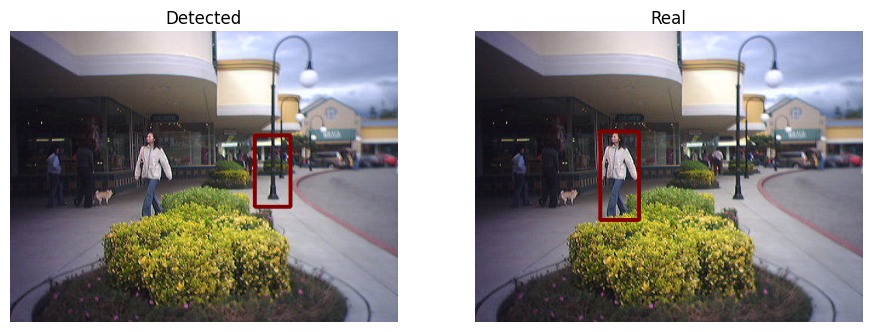

In [30]:
no = 6
show_comparison(no)

In [31]:
TP6, FP6, FN6 = 0, 1, 1
precision6, recall6, F1_score6, j_mean6 = get_metrics(TP6, FP6, FN6, no)

precisions_list.append(precision6)
recalls_list.append(recall6)
f1_scores_list.append(F1_score6)
jis_list.append(j_mean6)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 7

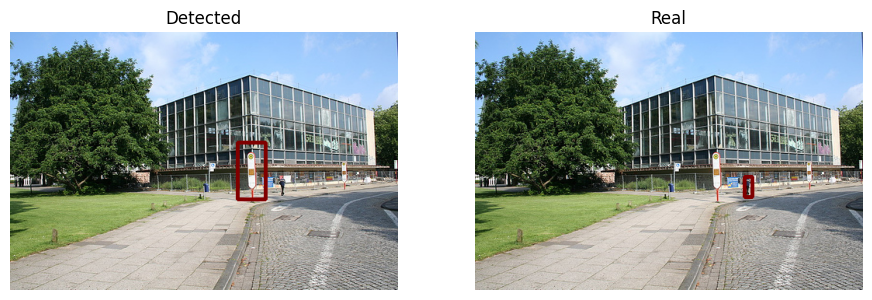

In [32]:
no = 7
show_comparison(no)

In [33]:
TP7, FP7, FN7 = 0, 1, 1
precision7, recall7, F1_score7, j_mean7 = get_metrics(TP7, FP7, FN7, no)

precisions_list.append(precision7)
recalls_list.append(recall7)
f1_scores_list.append(F1_score7)
jis_list.append(j_mean7)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 8

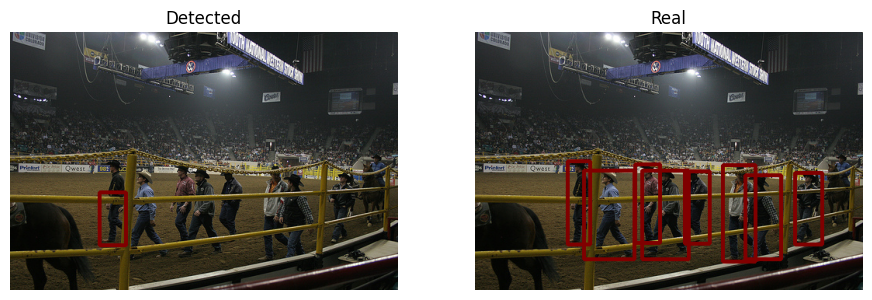

In [34]:
no = 8
show_comparison(no)

In [35]:
TP8, FP8, FN8 = 1, 0, 8
precision8, recall8, F1_score8, j_mean8 = get_metrics(TP8, FP8, FN8, no)

precisions_list.append(precision8)
recalls_list.append(recall8)
f1_scores_list.append(F1_score8)
jis_list.append(j_mean8)

Precision: 1.0
Recall: 0.1111111111111111
F1 Score: 0.19999999999999998
Jaccard Indexes: [0.5596198156682026, 0.06717892425905586]
Jaccard Index(Mean): 0.31339936996362927


### Imagen 9

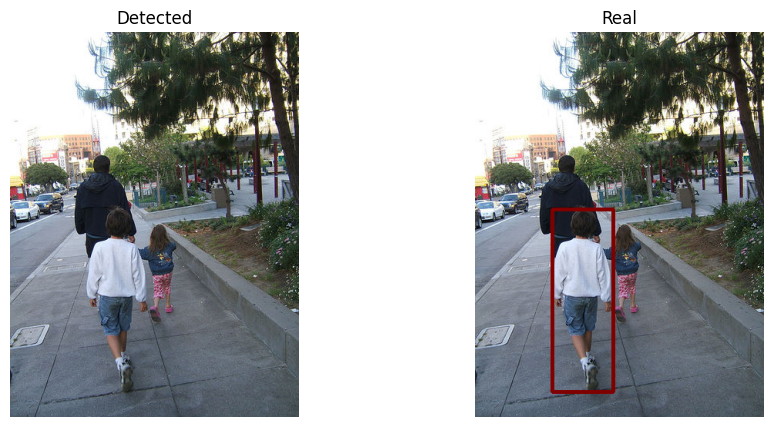

In [36]:
no = 9
show_comparison(no)

In [37]:
TP9, FP9, FN9 = 0, 0, 1
precision9, recall9, F1_score9, j_mean9 = get_metrics(TP9, FP9, FN9, no)

precisions_list.append(precision9)
recalls_list.append(recall9)
f1_scores_list.append(F1_score9)
jis_list.append(j_mean9)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 10

In [38]:
no = 10
show_comparison(no)

In [39]:
TP11, FP11, FN11 = 1, 0, 6
precision10, recall10, F1_score10, j_mean10 = get_metrics(TP11, FP11, FN11, no)

precisions_list.append(precision10)
recalls_list.append(recall10)
f1_scores_list.append(F1_score10)
jis_list.append(j_mean10)


Precision: 1.0
Recall: 0.14285714285714285
F1 Score: 0.25
Jaccard Indexes: [0.02091717856386361]
Jaccard Index(Mean): 0.02091717856386361


### Imagen 11

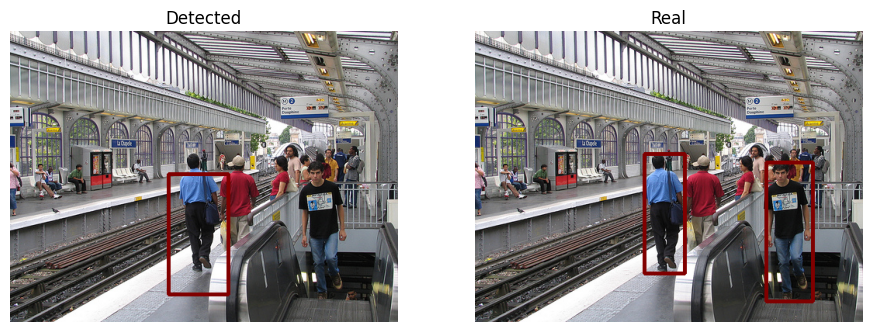

In [40]:
no = 11
show_comparison(no)

In [41]:
TP11, FP11, FN11 = 1, 0, 13

precision11, recall11, F1_score11, j_mean11 = get_metrics(TP11, FP11, FN11, no)

precisions_list.append(precision11)
recalls_list.append(recall11)
f1_scores_list.append(F1_score11)
jis_list.append(j_mean11)

Precision: 1.0
Recall: 0.07142857142857142
F1 Score: 0.13333333333333333
Jaccard Indexes: [0.5009407691728757]
Jaccard Index(Mean): 0.5009407691728757


### Imagen 12

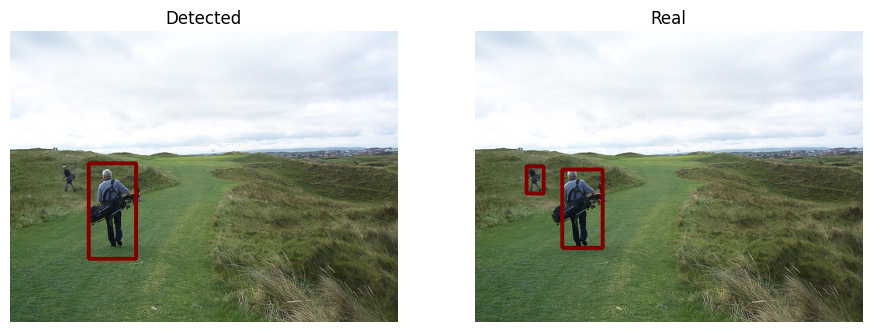

In [42]:
no = 12
show_comparison(no)

In [43]:
TP12, FP12, FN12 = 1, 0, 1
precision12, recall12, F1_score12, j_mean12 = get_metrics(TP12, FP12, FN12, no)

precisions_list.append(precision12)
recalls_list.append(recall12)
f1_scores_list.append(F1_score12)
jis_list.append(j_mean12)

Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
Jaccard Indexes: [0.655418559377028]
Jaccard Index(Mean): 0.655418559377028


### Imagen 13

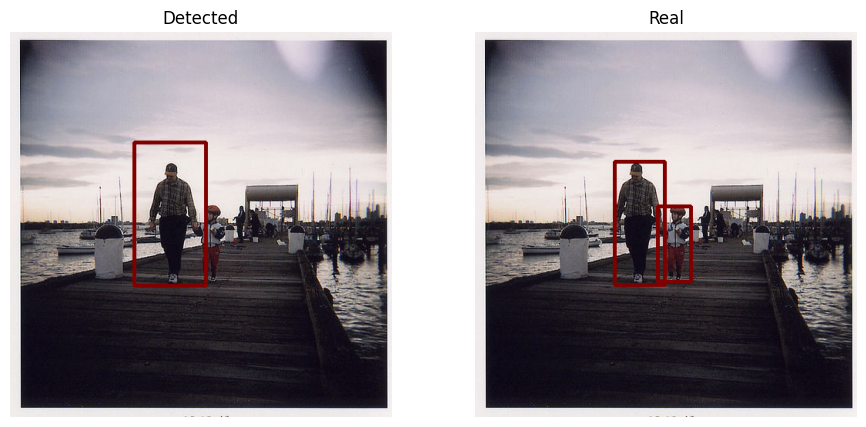

In [44]:
no = 13
show_comparison(no)

In [45]:
TP13, FP13, FN13 = 1, 0, 1
precision13, recall13, F1_score13, j_mean13 = get_metrics(TP13, FP13, FN13, no)

precisions_list.append(precision13)
recalls_list.append(recall13)
f1_scores_list.append(F1_score13)
jis_list.append(j_mean13)

Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
Jaccard Indexes: [0.601225575211007, 0.08394638718129589]
Jaccard Index(Mean): 0.3425859811961514


### Imagen 14

In [46]:
n = 14
show_comparison(n)

In [47]:
TP14, FP14, FN14 = 0, 0, 2
precision14, recall14, f1_score14, j_mean14 = get_metrics(TP14, FP14, FN14, n)

precisions_list.append(precision14)
recalls_list.append(recall14)
f1_scores_list.append(f1_score14)
jis_list.append(j_mean14)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 15

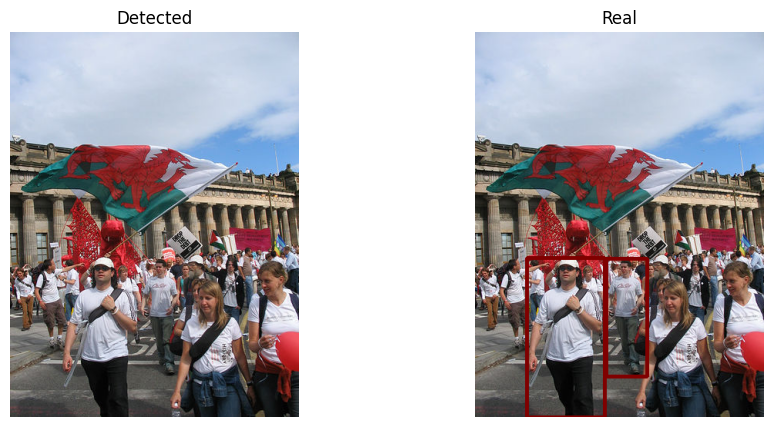

In [48]:
no = 15
show_comparison(no)

In [49]:
TP15, FP15, FN15 = 0, 0, 10
precision15, recall15, f1_score15, j_mean15 = get_metrics(TP15, FP15, FN15, no)

precisions_list.append(precision15)
recalls_list.append(recall15)
f1_scores_list.append(f1_score15)
jis_list.append(j_mean15)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 16

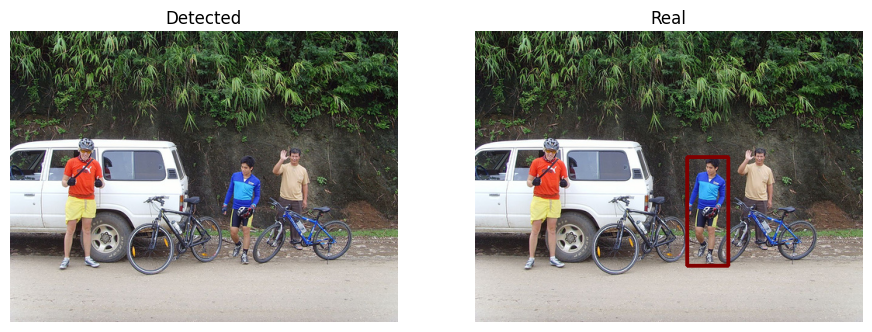

In [50]:
no = 16
show_comparison(no)

In [51]:
TP16, FP16, FN16 = 0, 0, 3
precision16, recall16, f1_score16, j_mean16 = get_metrics(TP16, FP16, FN16, no)

precisions_list.append(precision16)
recalls_list.append(recall16)
f1_scores_list.append(f1_score16)
jis_list.append(j_mean16)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 17

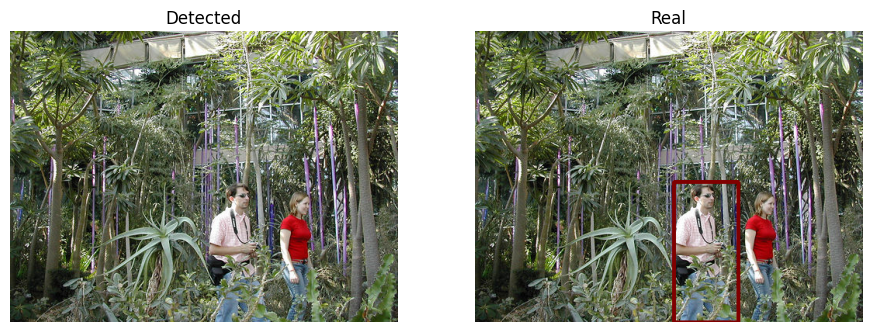

In [52]:
no = 17
show_comparison(no)

In [53]:
TP17, FP17, FN17 = 0, 0, 2
precision17, recall17, f1_score17, j_mean17 = get_metrics(TP17, FP17, FN17, no)

precisions_list.append(precision17)
recalls_list.append(recall17)
f1_scores_list.append(f1_score17)
jis_list.append(j_mean17)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 18

In [54]:
no = 18
show_comparison(no)

In [55]:
TP18, FP18, FN18 = 0, 0, 2
precision18, recall18, f1_score18, j_mean18 = get_metrics(TP18, FP18, FN18, no)

precisions_list.append(precision18)
recalls_list.append(recall18)
f1_scores_list.append(f1_score18)
jis_list.append(j_mean18)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 19

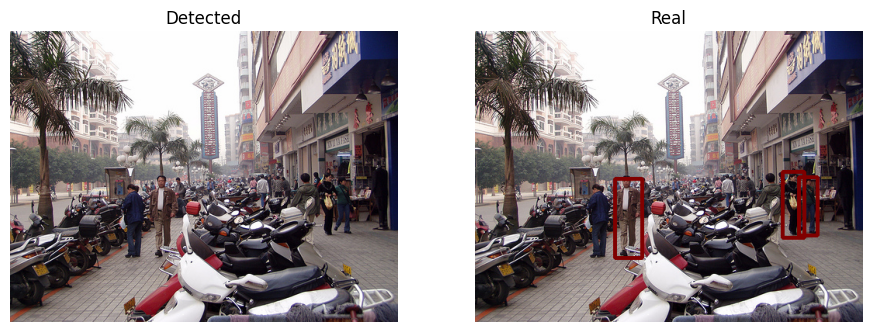

In [56]:
no = 19
show_comparison(no)

In [57]:
TP19, FP19, FN19 = 0, 0, 5
precision19, recall19, f1_score19, j_mean19 = get_metrics(TP19, FP19, FN19, no)

precisions_list.append(precision19)
recalls_list.append(recall19)
f1_scores_list.append(f1_score19)
jis_list.append(j_mean19)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 20

In [58]:
no = 20
show_comparison(no)

In [59]:
TP20, FP20, FN20 = 1, 0, 5
precision20, recall20, f1_score20, j_mean20 = get_metrics(TP20, FP20, FN20, no)

precisions_list.append(precision20)
recalls_list.append(recall20)
f1_scores_list.append(f1_score20)
jis_list.append(j_mean20)

Precision: 1.0
Recall: 0.16666666666666666
F1 Score: 0.2857142857142857
Jaccard Indexes: [0.6083025546321944]
Jaccard Index(Mean): 0.6083025546321944


### Imagen 21

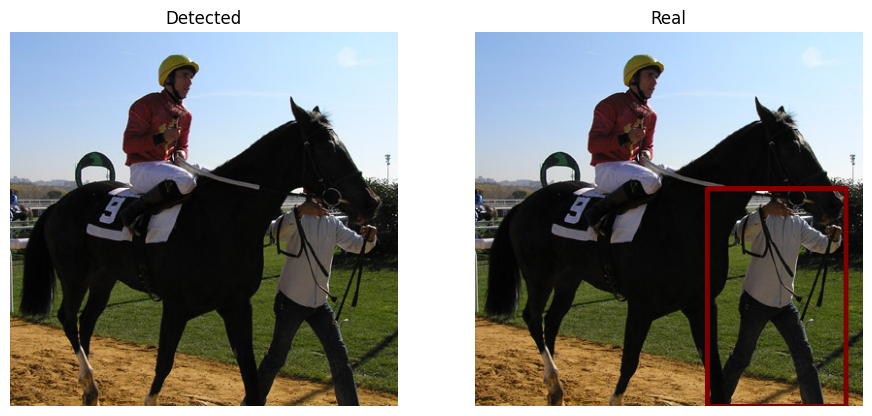

In [60]:
no = 21
show_comparison(no)

In [61]:
TP21, FP21, FN21 = 0, 0, 2
precision21, recall21, f1_score21, j_mean21 = get_metrics(TP21, FP21, FN21, no)

precisions_list.append(precision21)
recalls_list.append(recall21)
f1_scores_list.append(f1_score21)
jis_list.append(j_mean21)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 22

In [62]:
no = 22
show_comparison(no)

In [63]:
TP22, FP22, FN22 = 0, 0, 1
precision22, recall22, f1_score22, j_mean22 = get_metrics(TP22, FP22, FN22, no)

precisions_list.append(precision22)
recalls_list.append(recall22)
f1_scores_list.append(f1_score22)
jis_list.append(j_mean22)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 23

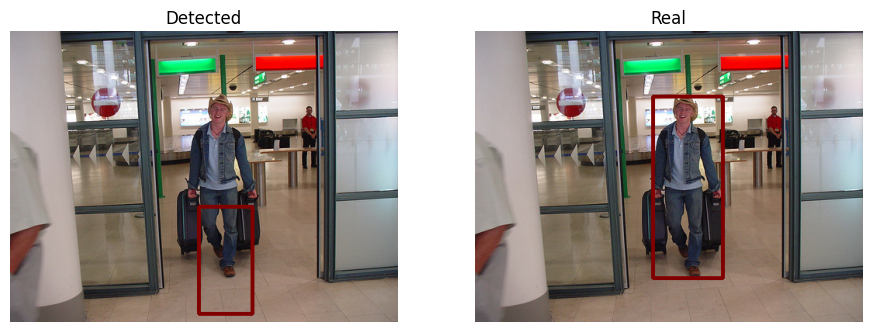

In [64]:
no = 23
show_comparison(no)

In [65]:
TP23, FP23, FN23 = 0, 1, 1
precision23, recall23, f1_score23, j_mean23 = get_metrics(TP23, FP23, FN23, no)

precisions_list.append(precision23)
recalls_list.append(recall23)
f1_scores_list.append(f1_score23)
jis_list.append(j_mean23)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: [0.26194602624411983]
Jaccard Index(Mean): 0.26194602624411983


### Imagen 24

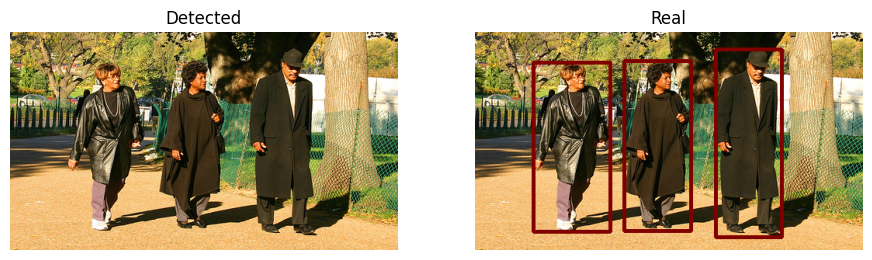

In [66]:
no = 24
show_comparison(no)

In [67]:
TP24, FP24, FN24 = 0, 0, 3
precision24, recall24, f1_score24, j_mean24 = get_metrics(TP24, FP24, FN24, no)

precisions_list.append(precision24)
recalls_list.append(recall24)
f1_scores_list.append(f1_score24)
jis_list.append(j_mean24)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA


### Imagen 25

In [68]:
no = 25
show_comparison(no)

In [69]:
TP25, FP25, FN25 = 0, 0, 1
precision25, recall25, f1_score25, j_mean25 = get_metrics(TP25, FP25, FN25, no)

precisions_list.append(precision25)
recalls_list.append(recall25)
f1_scores_list.append(f1_score25)
jis_list.append(j_mean25)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Jaccard Indexes: []
Jaccard Index(Mean): NA
